# Import Libraries

In [1]:
import cv2
import numpy as np
import pandas as pd
import csv
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import pickle
from PIL import ImageOps, Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
# import tensorflowjs as tfjs

from tqdm import tqdm
from tensorflow.data import AUTOTUNE
from collections import Counter
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import StandardScaler, LabelEncoder, LabelBinarizer
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

2022-04-12 16:52:18.246669: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
tf.__version__

'2.5.0'

In [3]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2022-04-12 16:52:19.320816: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-12 16:52:19.322149: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-04-12 16:52:19.365796: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-12 16:52:19.366324: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:09:00.0 name: GeForce RTX 2080 SUPER computeCapability: 7.5
coreClock: 1.845GHz coreCount: 48 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 462.00GiB/s
2022-04-1

True

 returning NUMA node zero
2022-04-12 16:52:19.371350: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-12 16:52:19.371832: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1871] Adding visible gpu devices: 0
2022-04-12 16:52:19.371852: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-04-12 16:52:19.713365: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-04-12 16:52:19.713387: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1264]      0 
2022-04-12 16:52:19.713392: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1277] 0:   N 
2022-04-12 16:52:19.713580: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but ther

In [4]:
ROUND = 1
EXERCISE = 'half-burpee'
CUR_CLASS = 'out'
PREV_CLASS = 'in'
SUBFIX_VID_NAME = '_hard_vote'
REMOTE = True

# Hyperparameters

In [5]:
input_shape = (120, 120, 3)

patch_size = (2, 2)  # 2-by-2 sized patches
dropout_rate = 0.03  # Dropout rate
num_heads = 8  # Attention heads
embed_dim = 64  # Embedding dimension
num_mlp = 256  # MLP layer size
qkv_bias = True  # Convert embedded patches to query, key, and values with a learnable additive value
window_size = 2  # Size of attention window
shift_size = 1  # Size of shifting window
image_dimension = 120  # Initial image size

num_patch_x = input_shape[0] // patch_size[0]
num_patch_y = input_shape[1] // patch_size[1]

# Load all file paths

In [6]:
all_file_paths = []
accepted_exts = ('.jpg', '.jpeg','.png')
if REMOTE:
    walk_path = f'/home/u6188041/jom/Dataset/EzFit_dataset/images/{EXERCISE}'
else:
    walk_path = f'D:\EzFit_dataset\images\len_{SEQ_LEN}\{EXERCISE}'
for path, subdirs, files in os.walk(walk_path):
    for name in files:
        if name.lower().endswith(accepted_exts):
            all_file_paths.append(os.path.join(path, name))

In [7]:
all_file_paths

['/home/u6188041/jom/Dataset/EzFit_dataset/images/half-burpee/others/others_210.jpg',
 '/home/u6188041/jom/Dataset/EzFit_dataset/images/half-burpee/others/others_217.jpg',
 '/home/u6188041/jom/Dataset/EzFit_dataset/images/half-burpee/others/others_156.jpg',
 '/home/u6188041/jom/Dataset/EzFit_dataset/images/half-burpee/others/others_157.jpg',
 '/home/u6188041/jom/Dataset/EzFit_dataset/images/half-burpee/others/others_38.jpg',
 '/home/u6188041/jom/Dataset/EzFit_dataset/images/half-burpee/others/others_88.jpg',
 '/home/u6188041/jom/Dataset/EzFit_dataset/images/half-burpee/others/others_6.jpg',
 '/home/u6188041/jom/Dataset/EzFit_dataset/images/half-burpee/others/others_245.jpg',
 '/home/u6188041/jom/Dataset/EzFit_dataset/images/half-burpee/others/others_123.jpg',
 '/home/u6188041/jom/Dataset/EzFit_dataset/images/half-burpee/others/others_40.jpg',
 '/home/u6188041/jom/Dataset/EzFit_dataset/images/half-burpee/others/others_19.jpg',
 '/home/u6188041/jom/Dataset/EzFit_dataset/images/half-burpe

In [8]:
len(all_file_paths)

756

In [9]:
# use for checking balance and stratify
labels = list(map(lambda x: x.split(os.path.sep)[-2], all_file_paths))
labels

['others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',

In [10]:
# check balanceness
total = len(labels)
label_count = Counter(labels)
label_count, total

(Counter({'others': 252, 'half-burpee-in': 252, 'half-burpee-out': 252}), 756)

# Preprocess

In [11]:
# fit to get all classes and we can use it in preprocess function in the data pipeline
le = LabelEncoder()
le.fit(labels)
le.classes_

array(['half-burpee-in', 'half-burpee-out', 'others'], dtype='<U15')

In [12]:
# train/test split from all paths
train_paths, test_paths = train_test_split(all_file_paths, test_size=0.1, random_state=42, stratify=labels)
len(train_paths), len(test_paths)

(680, 76)

In [13]:
# verify stratify
Counter(list(map(lambda x: x.split(os.path.sep)[-2], test_paths)))

Counter({'others': 26, 'half-burpee-in': 25, 'half-burpee-out': 25})

# Class weighting
Since we have a bit imbalanced data, so we should do class weighting  
formula derived from here: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#calculate_class_weights

In [14]:
NUM_CLASSES = len(le.classes_)
class_weights = {}
for label in label_count:
    class_weights[le.transform([label])[0]] = (1 / label_count[label]) * (total / NUM_CLASSES)

In [15]:
class_weights

{2: 1.0, 0: 1.0, 1: 1.0}

# Build data pipeline

In [16]:
EPOCHS = 150
BATCH_SIZE = 32
NUM_CLASSES = len(le.classes_)
INIT_LR = 1e-3

In [17]:
def load_data(image_path):
    # load data
    image = tf.io.read_file(image_path)
    image = tf.io.decode_png(image, channels=3)
    image = tf.image.resize(image, (120, 120)) / 255.0
    
    # parse label
    label = tf.strings.split(image_path, os.path.sep)[-2]
    one_hot = label == le.classes_
    one_hot = tf.cast(one_hot, tf.int32)
    return image, one_hot

In [18]:
train_ds = tf.data.Dataset.from_tensor_slices(train_paths)
train_ds = (train_ds
            .shuffle(len(train_paths), seed=42)
            .map(load_data, num_parallel_calls=AUTOTUNE)
            .cache()
            .batch(BATCH_SIZE)
            .prefetch(AUTOTUNE)
           )

2022-04-12 16:52:19.801019: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-12 16:52:19.801676: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:09:00.0 name: GeForce RTX 2080 SUPER computeCapability: 7.5
coreClock: 1.845GHz coreCount: 48 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 462.00GiB/s
2022-04-12 16:52:19.801758: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-12 16:52:19.802453: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-12 16:52:19.802902: I tensorflow/core/common

In [19]:
test_ds = tf.data.Dataset.from_tensor_slices(test_paths)
test_ds = (test_ds
            .map(load_data, num_parallel_calls=AUTOTUNE)
            .cache()
            .batch(BATCH_SIZE)
            .prefetch(AUTOTUNE)
           )

In [20]:
next(iter(train_ds))

2022-04-12 16:52:19.961917: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-04-12 16:52:19.963043: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3499880000 Hz
2022-04-12 16:52:20.003399: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


(<tf.Tensor: shape=(32, 120, 120, 3), dtype=float32, numpy=
 array([[[[0.6254902 , 0.6333333 , 0.5875817 ],
          [0.8568627 , 0.8686274 , 0.8254902 ],
          [0.81960785, 0.827451  , 0.78431374],
          ...,
          [0.99477124, 0.9895425 , 0.99215686],
          [0.99477124, 0.9895425 , 0.99215686],
          [0.99477124, 0.9895425 , 0.99215686]],
 
         [[0.6117647 , 0.62352943, 0.5803922 ],
          [0.84117645, 0.85294116, 0.8098039 ],
          [0.69411767, 0.7019608 , 0.6509804 ],
          ...,
          [0.99215686, 0.99215686, 0.99215686],
          [0.99215686, 0.99215686, 0.99215686],
          [0.99215686, 0.99215686, 0.99215686]],
 
         [[0.6156863 , 0.6124183 , 0.5601308 ],
          [0.66078436, 0.6542484 , 0.6124183 ],
          [0.7562092 , 0.76405233, 0.71307194],
          ...,
          [0.99215686, 0.99215686, 0.99215686],
          [0.99215686, 0.99215686, 0.99215686],
          [0.99215686, 0.99215686, 0.99215686]],
 
         ...,
 
      

# Build Model

## Helper functions

In [21]:
def window_partition(x, window_size):
    _, height, width, channels = x.shape
    patch_num_y = height // window_size
    patch_num_x = width // window_size
    x = tf.reshape(
        x, shape=(-1, patch_num_y, window_size, patch_num_x, window_size, channels)
    )
    x = tf.transpose(x, (0, 1, 3, 2, 4, 5))
    windows = tf.reshape(x, shape=(-1, window_size, window_size, channels))
    return windows


def window_reverse(windows, window_size, height, width, channels):
    patch_num_y = height // window_size
    patch_num_x = width // window_size
    x = tf.reshape(
        windows,
        shape=(-1, patch_num_y, patch_num_x, window_size, window_size, channels),
    )
    x = tf.transpose(x, perm=(0, 1, 3, 2, 4, 5))
    x = tf.reshape(x, shape=(-1, height, width, channels))
    return x


class DropPath(layers.Layer):
    def __init__(self, drop_prob=None, **kwargs):
        super(DropPath, self).__init__(**kwargs)
        self.drop_prob = drop_prob

    def call(self, x):
        input_shape = tf.shape(x)
        batch_size = input_shape[0]
        rank = x.shape.rank
        shape = (batch_size,) + (1,) * (rank - 1)
        random_tensor = (1 - self.drop_prob) + tf.random.uniform(shape, dtype=x.dtype)
        path_mask = tf.floor(random_tensor)
        output = tf.math.divide(x, 1 - self.drop_prob) * path_mask
        return output
    
    def get_config(self):
        config = super().get_config()
        config.update({
            'drop_prob': self.drop_prob,
        })
        return config

## Window based multi-head self-attention

In [22]:
class WindowAttention(layers.Layer):
    def __init__(
        self, dim, window_size, num_heads, qkv_bias=True, dropout_rate=0.0, **kwargs
    ):
        super(WindowAttention, self).__init__(**kwargs)
        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        self.scale = (dim // num_heads) ** -0.5
        self.qkv = layers.Dense(dim * 3, use_bias=qkv_bias)
        self.dropout = layers.Dropout(dropout_rate)
        self.proj = layers.Dense(dim)
        # added
        self.qkv_bias = qkv_bias
        self.dropout_rate = dropout_rate

    def build(self, input_shape):
        num_window_elements = (2 * self.window_size[0] - 1) * (
            2 * self.window_size[1] - 1
        )
        self.relative_position_bias_table = self.add_weight(
            shape=(num_window_elements, self.num_heads),
            initializer=tf.initializers.Zeros(),
            trainable=True,
        )
        coords_h = np.arange(self.window_size[0])
        coords_w = np.arange(self.window_size[1])
        coords_matrix = np.meshgrid(coords_h, coords_w, indexing="ij")
        coords = np.stack(coords_matrix)
        coords_flatten = coords.reshape(2, -1)
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
        relative_coords = relative_coords.transpose([1, 2, 0])
        relative_coords[:, :, 0] += self.window_size[0] - 1
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)

        self.relative_position_index = tf.Variable(
            initial_value=tf.convert_to_tensor(relative_position_index), trainable=False
        )

    def call(self, x, mask=None):
        _, size, channels = x.shape
        head_dim = channels // self.num_heads
        x_qkv = self.qkv(x)
        x_qkv = tf.reshape(x_qkv, shape=(-1, size, 3, self.num_heads, head_dim))
        x_qkv = tf.transpose(x_qkv, perm=(2, 0, 3, 1, 4))
        q, k, v = x_qkv[0], x_qkv[1], x_qkv[2]
        q = q * self.scale
        k = tf.transpose(k, perm=(0, 1, 3, 2))
        attn = q @ k

        num_window_elements = self.window_size[0] * self.window_size[1]
        relative_position_index_flat = tf.reshape(
            self.relative_position_index, shape=(-1,)
        )
        relative_position_bias = tf.gather(
            self.relative_position_bias_table, relative_position_index_flat
        )
        relative_position_bias = tf.reshape(
            relative_position_bias, shape=(num_window_elements, num_window_elements, -1)
        )
        relative_position_bias = tf.transpose(relative_position_bias, perm=(2, 0, 1))
        attn = attn + tf.expand_dims(relative_position_bias, axis=0)

        if mask is not None:
            nW = mask.get_shape()[0]
            mask_float = tf.cast(
                tf.expand_dims(tf.expand_dims(mask, axis=1), axis=0), tf.float32
            )
            attn = (
                tf.reshape(attn, shape=(-1, nW, self.num_heads, size, size))
                + mask_float
            )
            attn = tf.reshape(attn, shape=(-1, self.num_heads, size, size))
            attn = keras.activations.softmax(attn, axis=-1)
        else:
            attn = keras.activations.softmax(attn, axis=-1)
        attn = self.dropout(attn)

        x_qkv = attn @ v
        x_qkv = tf.transpose(x_qkv, perm=(0, 2, 1, 3))
        x_qkv = tf.reshape(x_qkv, shape=(-1, size, channels))
        x_qkv = self.proj(x_qkv)
        x_qkv = self.dropout(x_qkv)
        return x_qkv
    
    def get_config(self):
        config = super().get_config()
        config.update({
            'dim': self.dim,
            'window_size': self.window_size,
            'num_heads': self.num_heads,
            'qkv_bias': self.qkv_bias,
            'dropout_rate': self.dropout_rate
        })
        return config

## Complete model

In [23]:
class SwinTransformer(layers.Layer):
    def __init__(
        self,
        dim,
        num_patch,
        num_heads,
        window_size=7,
        shift_size=0,
        num_mlp=1024,
        qkv_bias=True,
        dropout_rate=0.0,
        **kwargs,
    ):
        super(SwinTransformer, self).__init__(**kwargs)

        self.dim = dim  # number of input dimensions
        self.num_patch = num_patch  # number of embedded patches
        self.num_heads = num_heads  # number of attention heads
        self.window_size = window_size  # size of window
        self.shift_size = shift_size  # size of window shift
        self.num_mlp = num_mlp  # number of MLP nodes
        # added
        self.qkv_bias = qkv_bias
        self.dropout_rate = dropout_rate

        self.norm1 = layers.LayerNormalization(epsilon=1e-5)
        self.attn = WindowAttention(
            dim,
            window_size=(self.window_size, self.window_size),
            num_heads=num_heads,
            qkv_bias=qkv_bias,
            dropout_rate=dropout_rate,
        )
        self.drop_path = DropPath(dropout_rate)
        self.norm2 = layers.LayerNormalization(epsilon=1e-5)

        self.mlp = keras.Sequential(
            [
                layers.Dense(num_mlp),
                layers.Activation(keras.activations.gelu),
                layers.Dropout(dropout_rate),
                layers.Dense(dim),
                layers.Dropout(dropout_rate),
            ]
        )

        if min(self.num_patch) < self.window_size:
            self.shift_size = 0
            self.window_size = min(self.num_patch)

    def build(self, input_shape):
        if self.shift_size == 0:
            self.attn_mask = None
        else:
            height, width = self.num_patch
            h_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None),
            )
            w_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None),
            )
            mask_array = np.zeros((1, height, width, 1))
            count = 0
            for h in h_slices:
                for w in w_slices:
                    mask_array[:, h, w, :] = count
                    count += 1
            mask_array = tf.convert_to_tensor(mask_array)

            # mask array to windows
            mask_windows = window_partition(mask_array, self.window_size)
            mask_windows = tf.reshape(
                mask_windows, shape=[-1, self.window_size * self.window_size]
            )
            attn_mask = tf.expand_dims(mask_windows, axis=1) - tf.expand_dims(
                mask_windows, axis=2
            )
            attn_mask = tf.where(attn_mask != 0, -100.0, attn_mask)
            attn_mask = tf.where(attn_mask == 0, 0.0, attn_mask)
            self.attn_mask = tf.Variable(initial_value=attn_mask, trainable=False)

    def call(self, x):
        height, width = self.num_patch
        _, num_patches_before, channels = x.shape
        x_skip = x
        x = self.norm1(x)
        x = tf.reshape(x, shape=(-1, height, width, channels))
        if self.shift_size > 0:
            shifted_x = tf.roll(
                x, shift=[-self.shift_size, -self.shift_size], axis=[1, 2]
            )
        else:
            shifted_x = x

        x_windows = window_partition(shifted_x, self.window_size)
        x_windows = tf.reshape(
            x_windows, shape=(-1, self.window_size * self.window_size, channels)
        )
        attn_windows = self.attn(x_windows, mask=self.attn_mask)

        attn_windows = tf.reshape(
            attn_windows, shape=(-1, self.window_size, self.window_size, channels)
        )
        shifted_x = window_reverse(
            attn_windows, self.window_size, height, width, channels
        )
        if self.shift_size > 0:
            x = tf.roll(
                shifted_x, shift=[self.shift_size, self.shift_size], axis=[1, 2]
            )
        else:
            x = shifted_x

        x = tf.reshape(x, shape=(-1, height * width, channels))
        x = self.drop_path(x)
        x = x_skip + x
        x_skip = x
        x = self.norm2(x)
        x = self.mlp(x)
        x = self.drop_path(x)
        x = x_skip + x
        return x
    
    def get_config(self):
        config = super().get_config()
        config.update({
            'dim': self.dim,
            'window_size': self.window_size,
            'num_heads': self.num_heads,
            'num_patch': self.num_patch,
            'shift_size': self.shift_size,
            'num_mlp': self.num_mlp,
            'qkv_bias': self.qkv_bias,
            'dropout_rate': self.dropout_rate
        })
        return config

## Extract and embed patches
We first create 3 layers to help us extract, embed and merge patches from the images on top of which we will later use the Swin Transformer class we built.

In [24]:
class PatchExtract(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super(PatchExtract, self).__init__(**kwargs)
        self.patch_size = patch_size
        self.patch_size_x = patch_size[0]
        self.patch_size_y = patch_size[0]

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=(1, self.patch_size_x, self.patch_size_y, 1),
            strides=(1, self.patch_size_x, self.patch_size_y, 1),
            rates=(1, 1, 1, 1),
            padding="VALID",
        )
        patch_dim = patches.shape[-1]
        patch_num = patches.shape[1]
        return tf.reshape(patches, (batch_size, patch_num * patch_num, patch_dim))
    
    def get_config(self):
        config = super().get_config()
        config.update({
            'patch_size': self.patch_size,
        })
        return config


class PatchEmbedding(layers.Layer):
    def __init__(self, num_patch, embed_dim, **kwargs):
        super(PatchEmbedding, self).__init__(**kwargs)
        self.num_patch = num_patch
        self.embed_dim = embed_dim
        self.proj = layers.Dense(embed_dim)
        self.pos_embed = layers.Embedding(input_dim=num_patch, output_dim=embed_dim)

    def call(self, patch):
        pos = tf.range(start=0, limit=self.num_patch, delta=1)
        return self.proj(patch) + self.pos_embed(pos)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            'num_patch': self.num_patch,
            'embed_dim': self.embed_dim
        })
        return config


class PatchMerging(tf.keras.layers.Layer):
    def __init__(self, num_patch, embed_dim, **kwargs):
        super(PatchMerging, self).__init__(**kwargs)
        self.num_patch = num_patch
        self.embed_dim = embed_dim
        self.linear_trans = layers.Dense(2 * embed_dim, use_bias=False)

    def call(self, x):
        height, width = self.num_patch
        _, _, C = x.get_shape().as_list()
        x = tf.reshape(x, shape=(-1, height, width, C))
        x0 = x[:, 0::2, 0::2, :]
        x1 = x[:, 1::2, 0::2, :]
        x2 = x[:, 0::2, 1::2, :]
        x3 = x[:, 1::2, 1::2, :]
        x = tf.concat((x0, x1, x2, x3), axis=-1)
        x = tf.reshape(x, shape=(-1, (height // 2) * (width // 2), 4 * C))
        return self.linear_trans(x)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            'num_patch': self.num_patch,
            'embed_dim': self.embed_dim
        })
        return config

## Build & Train model

In [25]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

In [26]:
from tensorflow.keras.layers.experimental.preprocessing import RandomCrop, RandomFlip

In [27]:
input = layers.Input(input_shape)
x = RandomCrop(image_dimension, image_dimension)(input)
x = RandomFlip("horizontal")(x)
x = PatchExtract(patch_size)(x)
x = PatchEmbedding(num_patch_x * num_patch_y, embed_dim)(x)
x = SwinTransformer(
    dim=embed_dim,
    num_patch=(num_patch_x, num_patch_y),
    num_heads=num_heads,
    window_size=window_size,
    shift_size=0,
    num_mlp=num_mlp,
    qkv_bias=qkv_bias,
    dropout_rate=dropout_rate,
)(x)
x = SwinTransformer(
    dim=embed_dim,
    num_patch=(num_patch_x, num_patch_y),
    num_heads=num_heads,
    window_size=window_size,
    shift_size=shift_size,
    num_mlp=num_mlp,
    qkv_bias=qkv_bias,
    dropout_rate=dropout_rate,
)(x)
x = PatchMerging((num_patch_x, num_patch_y), embed_dim=embed_dim)(x)
x = layers.GlobalAveragePooling1D()(x)
output = layers.Dense(NUM_CLASSES, activation="softmax")(x)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


In [28]:
model = keras.Model(input, output, name='Swin_act')

In [29]:
model.summary()

Model: "Swin_act"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 120, 120, 3)]     0         
_________________________________________________________________
random_crop (RandomCrop)     (None, 120, 120, 3)       0         
_________________________________________________________________
random_flip (RandomFlip)     (None, 120, 120, 3)       0         
_________________________________________________________________
patch_extract (PatchExtract) (None, 3600, 12)          0         
_________________________________________________________________
patch_embedding (PatchEmbedd (None, 3600, 64)          231232    
_________________________________________________________________
swin_transformer (SwinTransf (None, 3600, 64)          50072     
_________________________________________________________________
swin_transformer_1 (SwinTran (None, 3600, 64)          644

In [30]:
optimizer = tf.keras.optimizers.Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
# optimizer = tf.keras.optimizers.Adam(learning_rate=INIT_LR)

In [31]:
def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer._decayed_lr(tf.float32)
    return lr
lr_metric = get_lr_metric(optimizer)

In [32]:
# model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', lr_metric])
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [33]:
model.fit(train_ds,
          validation_data=test_ds,
          epochs=EPOCHS, 
          callbacks=[early_stopping],
          class_weight=class_weights)

Epoch 1/150


2022-04-12 16:52:22.717268: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11


 1/22 [>.............................] - ETA: 46s - loss: 2.4450 - accuracy: 0.2812

2022-04-12 16:52:23.055425: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


22/22 [==============================] - 5s 139ms/step - loss: 1.5917 - accuracy: 0.3691 - val_loss: 1.2326 - val_accuracy: 0.3289
Epoch 2/150
22/22 [==============================] - 3s 121ms/step - loss: 1.1528 - accuracy: 0.3471 - val_loss: 1.1489 - val_accuracy: 0.3684
Epoch 3/150
22/22 [==============================] - 3s 122ms/step - loss: 1.0934 - accuracy: 0.3926 - val_loss: 1.1432 - val_accuracy: 0.3158
Epoch 4/150
22/22 [==============================] - 3s 121ms/step - loss: 1.0909 - accuracy: 0.3647 - val_loss: 1.1222 - val_accuracy: 0.3421
Epoch 5/150
22/22 [==============================] - 3s 121ms/step - loss: 1.0895 - accuracy: 0.3676 - val_loss: 1.1148 - val_accuracy: 0.3684
Epoch 6/150
22/22 [==============================] - 3s 121ms/step - loss: 1.0836 - accuracy: 0.3809 - val_loss: 1.0878 - val_accuracy: 0.3553
Epoch 7/150
22/22 [==============================] - 3s 121ms/step - loss: 1.0619 - accuracy: 0.3941 - val_loss: 1.0921 - val_accuracy: 0.3684
Epoch 8/150

# Setup all dirs
*Note:* You have to create visualization dir at the bottom most manually

In [34]:
import os

In [35]:
all_dirs = []
model_dir = f'saved_models/round_{ROUND}/{EXERCISE}/'
all_dirs.append(model_dir)
pickle_dir = f'saved_pickles/round_{ROUND}/{EXERCISE}/'
all_dirs.append(pickle_dir)
output_vid_dir = f'output_videos/round_{ROUND}/{EXERCISE}/'
all_dirs.append(output_vid_dir)

In [36]:
for d in all_dirs:
    if not os.path.exists(d):
        os.makedirs(d, exist_ok=True)

# Save model

In [37]:
# model.save(os.path.join(model_dir, f'{EXERCISE}_Swin.h5'), save_format='h5')

In [38]:
# not a good way to save model, but the tf method has some error
# so this still maybe better than saving nothing
with open(os.path.join(model_dir, f'{EXERCISE}_Swin_weights.pickle'), 'wb') as file:
    pickle.dump(model.get_weights(), file)

In [39]:
# serialize lb
with open(os.path.join(pickle_dir, f'{EXERCISE}_Swin_le.pickle'), 'wb') as file:
    pickle.dump(le, file)

# Evaluate the model

In [40]:
raw_preds_y = model.predict(test_ds)
preds_y = np.argmax(raw_preds_y, axis=1)
preds_y

array([2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 2, 2, 0, 0, 2, 0, 2, 2, 2, 0,
       2, 2, 2, 2, 2, 2, 1, 0, 0, 1, 2, 2, 0, 0, 2, 0, 0, 2, 0, 2, 0, 2,
       0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0,
       2, 2, 0, 0, 2, 0, 2, 2, 0, 0])

In [41]:
# get y label back from tf.data
raw_test_y = np.concatenate([y for x, y in test_ds], axis=0)
test_y = np.argmax(raw_test_y, axis=1)
test_y

array([2, 0, 0, 2, 0, 1, 0, 1, 0, 1, 0, 0, 2, 0, 1, 0, 2, 1, 2, 2, 2, 1,
       2, 2, 2, 2, 2, 2, 0, 1, 0, 0, 0, 2, 1, 0, 2, 2, 2, 2, 1, 2, 1, 2,
       1, 2, 1, 1, 2, 1, 0, 1, 1, 2, 0, 1, 0, 0, 0, 0, 1, 0, 1, 2, 0, 1,
       2, 1, 1, 1, 0, 1, 2, 0, 1, 0])

In [42]:
test_y_text = le.inverse_transform(test_y)
preds_y_text = le.inverse_transform(preds_y)

### Accuracy

In [43]:
_, acc = model.evaluate(test_ds)
print('Test accuracy:', acc)

3/3 [==============================] - 0s 26ms/step - loss: 0.8226 - accuracy: 0.5000
Test accuracy: 0.5


### Confusion Matrix

In [44]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [45]:
cm = confusion_matrix(test_y_text, preds_y_text, labels=le.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=le.classes_)

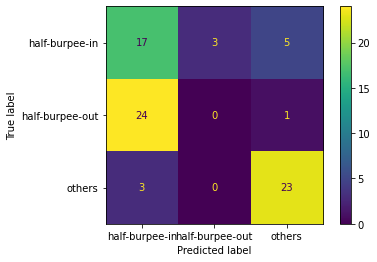

In [46]:
disp.plot()
plt.savefig(f'saved_artifacts/conf_matrix/final/{EXERCISE}/Swin_cm.png', dpi=300)
plt.show()

### ROC AUC

In [47]:
from sklearn.metrics import roc_auc_score

In [48]:
roc_auc_score(raw_test_y, raw_preds_y)

0.7542936148818503

# Make detection with model

In [49]:
# custom_objects = {'lr': lr_metric,
#                   'PatchMerging': PatchMerging,
#                   'PatchEmbedding': PatchEmbedding,
#                   'PatchExtract': PatchExtract,
#                   'SwinTransformer': SwinTransformer,
#                   'WindowAttention': WindowAttention,
#                   'DropPath': DropPath
#                  }
# loaded_model = tf.keras.models.load_model(os.path.join(model_dir, f'{EXERCISE}_Swin.h5'), custom_objects=custom_objects)

In [50]:
# Somehow, there a problem saving Swin Transformer :(
loaded_model = model

In [51]:
# loaded_model.inputs

In [52]:
# loaded_model.outputs

In [53]:
# tfjs.converters.save_keras_model(loaded_model, 'models/tfjs_models/RepCount_Pushup')

In [54]:
# serialize model and le
with open(os.path.join(pickle_dir, f'{EXERCISE}_Swin_le.pickle'), 'rb') as file:
    loaded_le = pickle.load(file)

In [55]:
from collections import deque, Counter

In [56]:
# SEQ_LEN = 8
NUM_TEST_VIDS = 3
for i in range(1,1+NUM_TEST_VIDS):
    rep_count = 0
    preds_window = deque(maxlen=15)
    current_stage = None
    previous_stage = None
    cap = cv2.VideoCapture(f'objective_test_videos/{EXERCISE}/{EXERCISE}_{i}.mp4')
    # video_width = int(cap.get(3))
    # video_height = int(cap.get(4))
    # video_size = (video_width, video_height)
    video_size = (640, 360)
    video_writer = cv2.VideoWriter(os.path.join(output_vid_dir, f'{EXERCISE}_{i}_Swin{SUBFIX_VID_NAME}.avi'), cv2.VideoWriter_fourcc(*'MJPG'),
                                   25, video_size)

    while cap.isOpened():
        success, frame = cap.read()
        if not success:
            break

        image = cv2.resize(frame, (640, 360))
        image_input = cv2.resize(frame, (120, 120)) / 255.0

        y_hat = loaded_model.predict(tf.expand_dims(image_input, axis=0))[0]
        y_idx = np.argmax(y_hat)
        
        if 'hard_vote' in SUBFIX_VID_NAME:
            # do hard voting
            preds_window.append(y_idx)
            pred_count = Counter(preds_window)
            # most_common return .items() format
            # ex. [(0,5), (1,3)]
            voted_pred = pred_count.most_common(1)[0][0]
            class_name = loaded_le.classes_[voted_pred]
        else:
            class_name = loaded_le.classes_[y_idx]
        
        prob = np.max(y_hat)
        print(y_hat, class_name, prob, end='\r')

        # count the rep logic
        current_stage = class_name

        if current_stage == f'{EXERCISE}-{CUR_CLASS}' and previous_stage == f'{EXERCISE}-{PREV_CLASS}':
            rep_count += 1

        previous_stage = current_stage

        print('rep:',rep_count, end='\r')

    #             image = cv2.resize(image, (640, 368))

        # status box at top left corner
        cv2.rectangle(image, (0,0), (320,60), (245,117,16), -1)

        # display class
        cv2.putText(image, 'Class', (95, 12),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
        cv2.putText(image, class_name, (95, 40),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)

        # display prob
        cv2.putText(image, 'Prob', (15, 12),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
        cv2.putText(image, str(round(np.max(prob),2)), (10, 40),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)

        # rep count box at top right corner
        cv2.rectangle(image, (580, 60), (640, 0), (245,117,16), -1)

        # display rep count
        cv2.putText(image, 'Rep', (640-52, 0+15),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
        cv2.putText(image, str(rep_count), (640-52, 0+50),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.25, (255,255,255), 2, cv2.LINE_AA)

        video_writer.write(image)
        if not REMOTE:
            cv2.imshow(f'{EXERCISE} Count Detection', image)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

    cap.release()
    video_writer.release()
    if not REMOTE:
        cv2.destroyAllWindows()

# Save class for visualization

In [57]:
NUM_TEST_VIDS = 3
for i in range(1, 1+NUM_TEST_VIDS):
    predicted_class = []
    preds_window = deque(maxlen=15)
    cap = cv2.VideoCapture(f'objective_test_videos/{EXERCISE}/{EXERCISE}_{i}.mp4')
    total_frame = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    video_size = (640, 360)
    
    while cap.isOpened():
        success, frame = cap.read()
        if not success:
            break

        image = cv2.resize(frame, (640, 360))
        image_input = cv2.resize(frame, (120, 120)) / 255.0

        y_hat = loaded_model.predict(tf.expand_dims(image_input, axis=0))[0]
        y_idx = np.argmax(y_hat)
        
        if 'hard_vote' in SUBFIX_VID_NAME:
            # do hard voting
            preds_window.append(y_idx)
            pred_count = Counter(preds_window)
            # most_common return .items() format
            # ex. [(0,5), (1,3)]
            voted_pred = pred_count.most_common(1)[0][0]
            class_name = loaded_le.classes_[voted_pred]
            predicted_class.append(voted_pred)
        else:
            class_name = loaded_le.classes_[y_idx]
            predicted_class.append(y_idx)
        
        prob = np.max(y_hat)
        print(y_hat, class_name, prob, end='\r')

        # status box at top left corner
        cv2.rectangle(image, (0,0), (320,60), (245,117,16), -1)

        # display class
        cv2.putText(image, 'Class', (95, 12),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
        cv2.putText(image, class_name, (95, 40),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)

        # display prob
        cv2.putText(image, 'Prob', (15, 12),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
        cv2.putText(image, str(round(np.max(prob),2)), (10, 40),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)

        # rep count box at top right corner
        cv2.rectangle(image, (580, 60), (640, 0), (245,117,16), -1)
        
        if not REMOTE:
            cv2.imshow(f'{EXERCISE} Count Detection', image)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

    assert len(predicted_class) == total_frame, f"# of label {len(predicted_class)} != # of frames in the video {total_frame}"
            
    temp_save_path = f'saved_pickles/for_visualization/{EXERCISE}/test_vid_{i}/round_{ROUND}'
    if not os.path.exists(temp_save_path):
        os.makedirs(temp_save_path, exist_ok=True)
    with open(os.path.join(temp_save_path, f'test_vid_{i}_Swin{SUBFIX_VID_NAME}.pickle'), 'wb') as f:
        pickle.dump(predicted_class, f)
    cap.release()
    if not REMOTE:
        cv2.destroyAllWindows()